# Srovnání SVD a randomizovaného SVD

Na provedení singulárního rozkladu (SVD) a randomizovaného singulárního rozkladu (randomized SVD) jsem se rozhodl využít třídu TruncatedSVD z knihovny scikit-learn, která implementuje naivní algoritmus (arpack) i randomizovaný algoritmus pro řídké matice, což umožňuje jednoduché porovnání obou algoritmů.

První je nutné naimportovat všechny potřebné knihovny, třídy a moduly:

In [89]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import timeit, tracemalloc

Načteme matice, se kterými budeme pracovat:

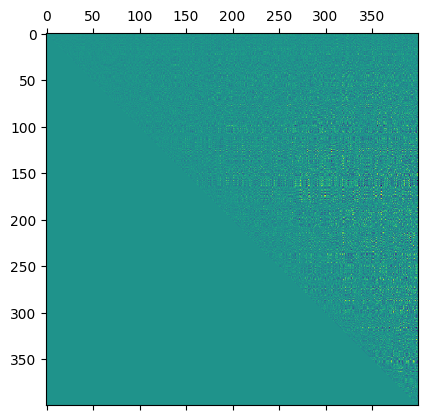

In [75]:
from scipy.linalg import lu
m = 400
n = 400
Md = np.random.rand(m, n)
_, L, U = lu(Md)
Md = U @ L.T
M = csr_matrix(Md)
plt.matshow(Md)

## Měření rychlosti
Pro účel měření rychlosti obou algoritmů jsem využil modul time, konkrétně jeho funkci perf_counter, která vrací aktuální čas v sekundách. Měření je provedeno pro různé cílové hodnosti aproximované matice, a to vícekrát za účelem snížení možných náhodných fluktuací ve výsledku.

In [112]:
def measure_time(M, x):
    y_arp = []
    y_ran = []

    for k in x:
        svd = TruncatedSVD(n_components=k, algorithm="arpack")
        rsvd = TruncatedSVD(n_components=k, algorithm="randomized")
        y_arp.append(timeit.timeit(lambda: svd.fit(M), number=10))
        y_ran.append(timeit.timeit(lambda: rsvd.fit(M), number=10))
    
    return np.array(y_arp), np.array(y_ran)

Dále vytvoříme funkci na vykreslení získaných hodnot:

In [113]:
def show_graph(x, y_arp, y_ran, title, ylabel, ax=None):
    if ax == None:
        fig, ax = plt.subplots()
    
    ax.set_title(title)
    ax.set_xlabel("Hodnost aproximované matice")
    ax.set_ylabel(ylabel)
    ax.plot(x, y_arp, "g.-", label="Arpack")
    ax.plot(x, y_ran, "r.-", label="Randomized")
    ax.set_xticks(x)
    ax.legend()

Vyzkoušíme na matici:

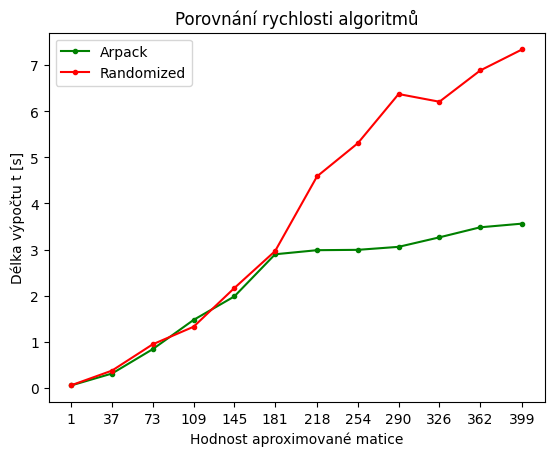

In [114]:
n_min = min(M.shape)
x = np.linspace(1, n_min-1, 12, dtype=int)

y_arp_t, y_ran_t = measure_time(M, x)
show_graph(x, y_arp_t, y_ran_t, "Porovnání rychlosti algoritmů", "Délka výpočtu t [s]")
plt.show()

## Měření paměti
Pro měření využití paměti jsem využil knihovnu tracemalloc, která dokáže nejlépe změřit množství alokované paměti. Jako dříve je měření provedeno několikrát pro různé hodnosti matice.

In [79]:
def measure_memory(M, x):
    y_arp = np.zeros_like(x, dtype=float)
    y_ran = np.zeros_like(x, dtype=float)
    repeat_times = 3
    svds = []
    tracemalloc.start()

    for _ in range(repeat_times):
        for i, k in enumerate(x):
            mem_before, _ = tracemalloc.get_traced_memory()
            svds.append(TruncatedSVD(n_components=k, algorithm="arpack"))
            svds[-1].fit(M)
            mem_after, _ = tracemalloc.get_traced_memory()
            y_arp[i] += mem_after - mem_before

            mem_before, _ = tracemalloc.get_traced_memory()
            svds.append(TruncatedSVD(n_components=k, algorithm="randomized"))
            svds[-1].fit(M)
            mem_after, _ = tracemalloc.get_traced_memory()
            y_ran[i] += mem_after - mem_before
    
    y_arp /= repeat_times
    y_ran /= repeat_times
    tracemalloc.stop()
    
    return y_arp, y_ran

Vyzkoušíme na matici:

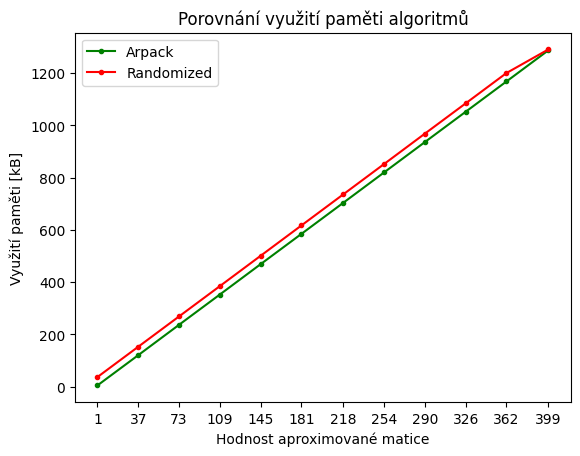

In [100]:
y_arp_m, y_ran_m = measure_memory(M, x)
show_graph(x, y_arp_m/1000, y_ran_m/1000, "Porovnání využití paměti algoritmů", "Využití paměti [kB]")
plt.show()

## Měření přesnosti aproximace
Přesnost $p$ aproximované matice $\tilde{M}$ k původní matici $M$ určíme například podle následujícího jednoduchého vzorečku

$$
\begin{equation}
p = 1 - \frac{\| \tilde{M} - M \|}{\| M \|},
\end{equation}
$$

kde $\| \cdot \|$ označuje Frobeniovu normu matice. Přesnost náleží intervalu $\langle 0, 1 \rangle$. Čím přesnější je aproximace, tím více se $p$ blíží $100 \%$.

In [81]:
def measure_accuracy(M, x):
    y_arp = []
    y_ran = []
    M_dense = M.todense("C")
    norm_exact = np.linalg.norm(M_dense)
    
    for k in x:
        svd = TruncatedSVD(n_components=k, algorithm="arpack")
        M_transformed = svd.fit_transform(M)
        M_tilde = M_transformed @ svd.components_
        norm_diff = np.linalg.norm(M_tilde - M_dense)
        y_arp.append(1 - norm_diff / norm_exact)

        rsvd = TruncatedSVD(n_components=k, algorithm="randomized")
        M_transformed = rsvd.fit_transform(M)
        M_tilde = M_transformed @ rsvd.components_
        norm_diff = np.linalg.norm(M_tilde - M_dense)
        y_ran.append(1 - norm_diff / norm_exact)
    
    return np.array(y_arp), np.array(y_ran)

Vyzkoušíme na matici:

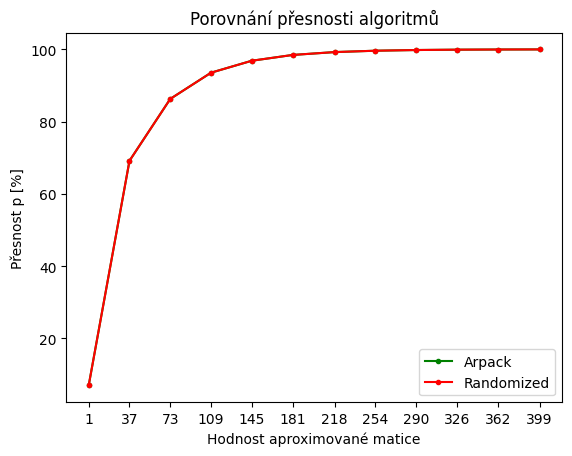

In [104]:
y_arp_a, y_ran_a = measure_accuracy(M, x)
show_graph(x, 100*y_arp_a, 100*y_ran_a, "Porovnání přesnosti algoritmů", "Přesnost p [%]")
plt.show()

## Analýza kompromisu mezi přesností a rychlostí
Hledáme takovou hodnost aproximované matice, pro kterou dostaneme co největší přesnost $p$ za co nejkratší čas $t$, tedy hledáme nejlepší poměr $p/t$.

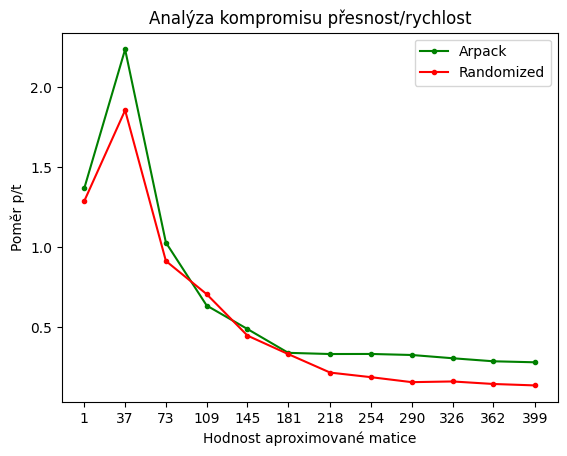

In [115]:
y_arp_k = y_arp_a / y_arp_t
y_ran_k = y_ran_a / y_ran_t
show_graph(x, y_arp_k, y_ran_k, "Analýza kompromisu přesnost/rychlost", "Poměr p/t")
plt.show()